In [190]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
import torch
import numpy as np
import pandas as pd
from pandas import DataFrame
from IPython.display import HTML
#HTML(DataFrame(MYDATA).to_html())
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)


In [192]:
#from fastai.imports import *
#from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
from plotnine import *

In [193]:
import sys
sys.path.append('/home/maghoi/fastai/old/')

from fastai_v7.imports import *
from fastai_v7.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
set_plot_sizes(12,14,16)

## Loading data

In [194]:
df_raw = pd.read_csv("/home/maghoi/main/data/complexes.csv", low_memory=False)
all_energy = pd.read_csv("/home/maghoi/main/data/All_Energy.csv", low_memory = False)

In [195]:
df_raw = df_raw.drop("Unnamed: 0", axis = 1)
#set index to first column then drop it
df_raw = df_raw.set_index(df_raw.iloc[:,0]).drop("key_0", axis = 1)
all_energy = all_energy.set_index(all_energy.iloc[:,0]).drop("Unnamed: 0", axis = 1)
all_energy.rename(columns = {"Unnamed: 0": "key_0"}, inplace = True)
all_energy.index.name = "key_0"
df_raw.index.name = "key_0"

In [196]:
df_raw = df_raw.drop("y_true", axis = 1)

In [197]:
#df_raw_all = pd.merge(df_raw.drop("y_true", axis = 1), all_energy, on = df_raw.index)

KeyError: "['y_true'] not found in axis"

In [198]:
df_raw_all = pd.merge(df_raw, all_energy, on=df_raw.index).set_index(df_raw.index).drop(columns="key_0")

In [199]:
df_raw_all.apply(pd.to_numeric)

ValueError: ('Unable to parse string "[\'5\', \'7\', \'9\', \'22\', \'24\', \'33\', \'34\', \'45\', \'59\', \'60\', \'62\', \'63\', \'64\', \'66\', \'67\', \'68\', \'71\', \'73\', \'74\', \'75\', \'77\', \'78\', \'81\', \'82\', \'85\', \'96\', \'98\', \'100\', \'115\', \'117\', \'124\', \'125\', \'144\', \'147\', \'148\', \'150\', \'151\', \'153\', \'155\', \'156\', \'158\', \'160\', \'161\', \'165\', \'168\', \'169\', \'173\']" at position 0', 'occurred at index M_intface')

In [200]:
from fastai.tabular import * 


### Pre-processing

In [216]:
#Create column of zeroes (negative complexes)
zeroes = np.zeros((len(df_raw_all),1))
zeroes = pd.DataFrame(zeroes).set_index(df_raw_all.index)

#Merge zeroes on the right of complex_df_raw_all
df_raw_all = pd.merge(df_raw_all, zeroes, on = df_raw_all.index);
df_raw_all = df_raw_all.rename(columns={0 : "y_true"})

#Change zero to 1 (true complex) for all true complexes
changes = df_raw_all[df_raw_all.iloc[:,0].str.contains("_P")].index
df_raw_all.loc[changes, "y_true"] = 1
df = df_raw_all

ValueError: cannot insert key_0, already exists

In [217]:
df.head()

0  1  2  3  4  5  6  7  8  9  ...  \
key_0                                                     ...   
1g6r_1p_P1_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   
1g6r_1p_N1_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   
1g6r_1p_N2_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   
1g6r_1p_N3_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   
1g6r_1p_R1_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   

                            AB_Number of Residues  AB_Interface Residues  \
key_0                                                                      
1g6r_1p_P1_1t_80s_pMHC-TCR                    460                     35   
1g6r_1p_N1_1t_80s_pMHC-TCR                    460                     34   
1g6r_1p_N2_1t_80s_pMHC-TCR                    460                     36   
1g6r_1p_N3_1t_80s_pMHC-TCR                    460                     33   
1g6r_1p_R1_1t_80s_pMHC-TCR                    460                     35   

                            AB_Interface Residues Clashing  \
key_0                                                        
1g6r_1p_P1_1t_80s_pMHC-TCR                               0   
1g6r_1p_N1_1t_80s_pMHC-TCR                               0   
1g6r_1p_N2_1t_80s_pMHC-TCR                               0   
1g6r_1p_N3_1t_80s_pMHC-TCR                               0   
1g6r_1p_R1_1t_80s_pMHC-TCR                               0   

                            AB_Interface Residues VdW Clashing  \
key_0                                                            
1g6r_1p_P1_1t_80s_pMHC-TCR                                   0   
1g6r_1p_N1_1t_80s_pMHC-TCR                                   0   
1g6r_1p_N2_1t_80s_pMHC-TCR                                   0   
1g6r_1p_N3_1t_80s_pMHC-TCR                                   0   
1g6r_1p_R1_1t_80s_pMHC-TCR                                   0   

                            AB_Interface Residues BB Clashing  \
key_0                                                           
1g6r_1p_P1_1t_80s_pMHC-TCR                                  0   
1g6r_1p_N1_1t_80s_pMHC-TCR                                  0   
1g6r_1p_N2_1t_80s_pMHC-TCR                                  0   
1g6r_1p_N3_1t_80s_pMHC-TCR                                  0   
1g6r_1p_R1_1t_80s_pMHC-TCR                                  0   

                                                                    M_intface  \
key_0                                                                           
1g6r_1p_P1_1t_80s_pMHC-TCR  ['5', '7', '9', '22', '24', '33', '34', '45', ...   
1g6r_1p_N1_1t_80s_pMHC-TCR  ['5', '7', '9', '22', '24', '33', '45', '59', ...   
1g6r_1p_N2_1t_80s_pMHC-TCR  ['5', '7', '9', '22', '24', '33', '45', '59', ...   
1g6r_1p_N3_1t_80s_pMHC-TCR  ['5', '7', '9', '22', '24', '45', '59', '60', ...   
1g6r_1p_R1_1t_80s_pMHC-TCR  ['5', '7', '9', '22', '24', '33', '45', '59', ...   

                                                           P_intface  \
key_0                                                                  
1g6r_1p_P1_1t_80s_pMHC-TCR       ['1', '2', '3', '4', '5', '6', '8']   
1g6r_1p_N1_1t_80s_pMHC-TCR  ['1', '2', '3', '4', '5', '6', '7', '8']   
1g6r_1p_N2_1t_80s_pMHC-TCR  ['1', '2', '3', '4', '5', '6', '7', '8']   
1g6r_1p_N3_1t_80s_pMHC-TCR  ['1', '2', '3', '4', '5', '6', '7', '8']   
1g6r_1p_R1_1t_80s_pMHC-TCR  ['1', '2', '3', '4', '5', '6', '7', '8']   

                                                                    A_intface  \
key_0                                                                           
1g6r_1p_P1_1t_80s_pMHC-TCR  ['27', '28', '36', '37', '39', '41', '43', '45...   
1g6r_1p_N1_1t_80s_pMHC-TCR  ['27', '28', '36', '37', '39', '41', '43', '45...   
1g6r_1p_N2_1t_80s_pMHC-TCR  ['27', '28', '36', '37', '38', '39', '41', '43...   
1g6r_1p_N3_1t_80s_pMHC-TCR  ['27', '28', '36', '37', '39', '41', '43', '45...   
1g6r_1p_R1_1t_80s_pMHC-TCR  ['2', '27', '28', '36', '38', '39', '41', '43'...   

                                            

In [239]:
df, y, nas = proc_df(df_raw_all, "y_true")

In [242]:
df = df
df["y_true"] = pd.DataFrame(df_raw_all["y_true"]).astype("int")

In [215]:
#df = df_raw_all.set_index(df_raw_all["key_0"]).drop("key_0", axis = 1); df

0  1  2  3  4  5  6  7  8  9  ...  \
key_0                                                     ...   
1g6r_1p_P1_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   
1g6r_1p_N1_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   
1g6r_1p_N2_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   
1g6r_1p_N3_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   
1g6r_1p_R1_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   
1g6r_1p_S1_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   
1g6r_1p_P1_1t_90s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_N1_1t_90s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_N2_1t_90s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_N3_1t_90s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_R1_1t_90s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_S1_1t_90s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_P1_1t_95s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_N1_1t_95s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_N2_1t_95s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_N3_1t_95s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_R1_1t_95s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_S1_1t_95s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_P1_1t_99s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_N1_1t_99s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_N2_1t_99s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_N3_1t_99s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_R1_1t_99s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1g6r_1p_S1_1t_99s_pMHC-TCR  6  7  8  4  4  5  7  6  4  5  ...   
1mwa_1p_P1_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   
1mwa_1p_N1_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   
1mwa_1p_N2_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   
1mwa_1p_N3_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   
1mwa_1p_R1_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   
1mwa_1p_S1_1t_80s_pMHC-TCR  6 -1  8  4  2  5  7  6 -1  5  ...   
...                        .. .. .. .. .. .. .. .. .. ..  ...   
5hho_4p_P1_1t_99s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5hho_4p_N1_1t_99s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5hho_4p_N2_1t_99s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5hho_4p_N3_1t_99s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5hho_4p_R1_1t_99s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5hho_4p_S1_1t_99s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_P1_1t_80s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_N1_1t_80s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_N2_1t_80s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_N3_1t_80s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_R1_1t_80s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_S1_1t_80s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_P1_1t_90s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_N1_1t_90s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_N2_1t_90s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_N3_1t_90s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_R1_1t_90s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_S1_1t_90s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_P1_1t_95s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_N1_1t_95s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_N2_1t_95s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_N3_1t_95s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_R1_1t_95s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_S1_1t_95s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_P1_1t_99s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_N1_1t_99s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_N2_1t_99s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_N3_1t_99s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...   
5men_0p_R1_1t_99s_pMHC-TCR  6  4  8  4  5  5  7  6  6  5  ...  

In [119]:
#df["y_true"] = df["y_true"].astype("int")

In [244]:
procs = [FillMissing, Categorify, Normalize]
dep_var = "y_true"
#cat_names = ["M_intface", "P_intface", "A_intface", "B_intface"]
path = "/home/maghoi/main/data"

In [245]:
valid_idx = range(len(df)-300, len(df))


In [307]:
df.iloc[valid_idx]

key_0  0  1  2  3  4  5  6  7  8  ...  AB_Number of Residues  \
1164   1239  6  4  8  4  5  5  7  6  6  ...                    463   
1165   1227  6  4  8  4  5  5  7  6  6  ...                    463   
1166   1231  6  4  8  4  5  5  7  6  6  ...                    463   
1167   1235  6  4  8  4  5  5  7  6  6  ...                    463   
1168   1243  6  4  8  4  5  5  7  6  6  ...                    463   
1169   1247  6  4  8  4  5  5  7  6  6  ...                    464   
1170   1240  6  4  8  4  5  5  7  6  6  ...                    463   
1171   1228  6  4  8  4  5  5  7  6  6  ...                    463   
1172   1232  6  4  8  4  5  5  7  6  6  ...                    463   
1173   1236  6  4  8  4  5  5  7  6  6  ...                    463   
1174   1244  6  4  8  4  5  5  7  6  6  ...                    463   
1175   1248  6  4  8  4  5  5  7  6  6  ...                    464   
1176   1261  6  4  8  4  5  5  7  6  6  ...                    463   
1177   1249  6  4  8  4  5  5  7  6  6  ...                    463   
1178   1253  6  4  8  4  5  5  7  6  6  ...                    463   
1179   1257  6  4  8  4  5  5  7  6  6  ...                    463   
1180   1265  6  4  8  4  5  5  7  6  6  ...                    463   
1181   1269  6  4  8  4  5  5  7  6  6  ...                    462   
1182   1262  6  4  8  4  5  5  7  6  6  ...                    463   
1183   1250  6  4  8  4  5  5  7  6  6  ...                    463   
1184   1254  6  4  8  4  5  5  7  6  6  ...                    463   
1185   1258  6  4  8  4  5  5  7  6  6  ...                    463   
1186   1266  6  4  8  4  5  5  7  6  6  ...                    463   
1187   1270  6  4  8  4  5  5  7  6  6  ...                    464   
1188   1263  6  4  8  4  5  5  7  6  6  ...                    463   
1189   1251  6  4  8  4  5  5  7  6  6  ...                    463   
1190   1255  6  4  8  4  5  5  7  6  6  ...                    463   
1191   1259  6  4  8  4  5  5  7  6  6  ...                    463   
1192   1267  6  4  8  4  5  5  7  6  6  ...                    463   
1193   1271  6  4  8  4  5  5  7  6  6  ...                    464   
...     ... .. .. .. .. .. .. .. .. ..  ...                    ...   
1434   1432  6  4  8  4  5  5  7  6  6  ...                    458   
1435   1420  6  4  8  4  5  5  7  6  6  ...                    458   
1436   1424  6  4  8  4  5  5  7  6  6  ...                    458   
1437   1428  6  4  8  4  5  5  7  6  6  ...                    458   
1438   1436  6  4  8  4  5  5  7  6  6  ...                    458   
1439   1440  6  4  8  4  5  5  7  6  6  ...                    462   
1440   1453  6  4  8  4  5  5  7  6  6  ...                    462   
1441   1441  6  4  8  4  5  5  7  6  6  ...                    462   
1442   1445  6  4  8  4  5  5  7  6  6  ...                    462   
1443   1449  6  4  8  4  5  5  7  6  6  ...                    462   
1444   1457  6  4  8  4  5  5  7  6  6  ...                    462   
1445   1461  6  4  8  4  5  5  7  6  6  ...                    459   
1446   1454  6  4  8  4  5  5  7  6  6  ...                    462   
1447   1442  6  4  8  4  5  5  7  6  6  ...                    462   
1448   1446  6  4  8  4  5  5  7  6  6  ...                    462   
1449   1450  6  4  8  4  5  5  7  6  6  ...                    462   
1450   1458  6  4  8  4  5  5  7  6  6  ...                    462   
1451   1462  6  4  8  4  5  5  7  6  6  ...                    459   
1452   1455  6  4  8  4  5  5  7  6  6  ...                    462   
1453   1443  6  4  8  4  5  5  7  6  6  ...                    462   
1454   1447  6  4  8  4  5  5  7  6  6  ...                    462   
1455   1451  6  4  8  4  5  5  7  6  6  ...                    462   
1456   1459  6  4  8  4  5  5  7  6  6  ...                    462   
1457   1463  6  4  8  4  5  5  7  6  6  ...                    459   
1458   1456  6  4  8  4  5  5  7  6  6  ...                    462   
1459   1444  6  

In [246]:
data = TabularDataBunch.from_df(path, df, dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_names)
print(data.train_ds.cont_names)  # `cont_names` defaults to: set(df)-set(cat_names)-{dep_var}

['132', 'PA_entropy mainchain', 'PA_Interaction Energy', 'PA_Solvation Polar', '203', 'PA_disulfide', 'P_entropy mainchain', '449', '28', '100', '444', '141', '210', '357', '283', '287', 'P_mloop_entropy', '19', '69', '197', '216', '16', 'PB_energy Ionisation', '461', '465', '364', '436', 'MA_disulfide', '165', '189', 'B_Backbone Hbond', '429', '269', '448', '396', '446', 'MA_Interaction Energy', '338', 'AB_energy Ionisation', '315', 'MP_disulfide', 'PB_Van der Waals clashes', '231', 'PB_Electrostatics', '245', '328', 'MP_entropy sidechain', 'P_Sidechain Hbond', 'key_0', '44', '421', 'M_disulfide', '5', '166', '329', '118', '22', '416', '317', '340', 'MP_entropy mainchain', '125', '218', 'PA_Interface Residues BB Clashing', '134', '85', '365', '200', '235', 'MA_torsional clash', '87', '98', '196', 'A_mloop_entropy', '354', 'A_helix dipole', '76', '179', 'B_cis_bond', '335', 'PB_partial covalent bonds', '150', '420', '360', 'MP_Number of Residues', '41', 'M_helix dipole', '133', 'A_sloo

In [247]:
(cat_x,cont_x),y = next(iter(data.train_dl))
for o in (cat_x, cont_x, y): print(to_np(o[:5]))

[[447   3 463 651]
 [311   4  84 906]
 [913   5 213  40]
 [ 18  33 323 849]
 [509   4 347 589]]
[[-0.016241 -0.523891 -0.265002 -0.772651 ...  2.026523  0.        0.       -0.239511]
 [-0.016241 -1.042016 -0.643229 -1.222919 ...  0.696585  0.        0.       -0.871792]
 [-4.067202  0.859968  0.479538  0.355808 ... -1.48751   0.        0.        0.837763]
 [-0.016241  1.038029  2.504825  1.790251 ... -1.222548  0.        0.        0.246635]
 [-0.016241 -0.474656  1.211014  0.159152 ... -0.647953  0.        0.        0.513076]]
[0 0 0 0 0]


In [327]:
doc(tabular_learner)

In [248]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)

In [249]:
learn.fit_one_cycle(4)

In [250]:
learn.save('stage-1')

In [323]:
learn.load("stage-1")

Learner(data=TabularDataBunch;

Train: LabelList
y: CategoryList (1164 items)
[Category 1, Category 0, Category 0, Category 0, Category 0]...
Path: /home/maghoi/main/data
x: TabularList (1164 items)
[TabularLine M_intface 224; P_intface 11; A_intface 239; B_intface 29; 132 -4.0672; PA_entropy mainchain -0.7282; PA_Interaction Energy -0.1675; PA_Solvation Polar -0.6329; 203 -0.3729; PA_disulfide 0.0000; P_entropy mainchain -0.8874; 449 0.0000; 28 0.0000; 100 0.0000; 444 0.2823; 141 -5.5385; 210 -1.1100; 357 0.0000; 283 -1.1497; 287 -1.5770; P_mloop_entropy 0.0000; 19 0.0000; 69 -3.7558; 197 -2.3055; 216 0.6073; 16 -4.4858; PB_energy Ionisation 2.6877; 461 0.0000; 465 -1.3595; 364 0.0000; 436 -1.3566; MA_disulfide -0.0000; 165 0.0000; 189 -1.5365; B_Backbone Hbond 0.0222; 429 0.6152; 269 -1.3757; 448 0.0000; 396 0.0000; 446 0.1569; MA_Interaction Energy -0.2721; 338 0.5114; AB_energy Ionisation -0.2428; 315 -0.7958; MP_disulfide 0.0000; PB_Van der Waals clashes -0.4826; 231 0.2192; PB_El

In [286]:
from fastai.imports import *
from fastai.vision import *
from fastai.metrics import error_rate

In [287]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [298]:
interp.confusion_matrix()

array([[243,   7],
       [ 12,  38]])

In [325]:
38/(12+38)

0.76

In [326]:
243/(243+7)

0.972

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


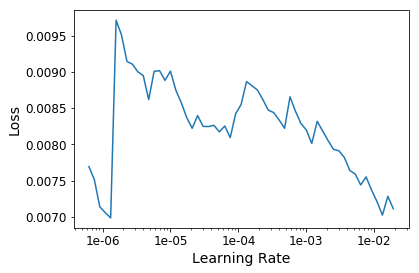

In [296]:
learn.lr_find()
learn.recorder.plot()

In [295]:
learn.fit_one_cycle(1, max_lr = 1e-03)

In [321]:
interp.y_true

tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [322]:
interp.pred_class

tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [318]:
learn.predict(df.iloc[6])

(Category 1, tensor(1), tensor([3.1382e-05, 9.9997e-01]))

In [320]:
df.iloc[valid_idx].y_true

1164    1
1165    0
1166    0
1167    0
1168    0
1169    0
1170    1
1171    0
1172    0
1173    0
1174    0
1175    0
1176    1
1177    0
1178    0
1179    0
1180    0
1181    0
1182    1
1183    0
1184    0
1185    0
1186    0
1187    0
1188    1
1189    0
1190    0
1191    0
1192    0
1193    0
       ..
1434    1
1435    0
1436    0
1437    0
1438    0
1439    0
1440    1
1441    0
1442    0
1443    0
1444    0
1445    0
1446    1
1447    0
1448    0
1449    0
1450    0
1451    0
1452    1
1453    0
1454    0
1455    0
1456    0
1457    0
1458    1
1459    0
1460    0
1461    0
1462    0
1463    0
Name: y_true, Length: 300, dtype: int64

In [ ]:
learn.save('stage0')

In [127]:
doc(tabular_learner)

In [ ]:
learn.fit_one_cycle(2, max_lr=slice(1e-7,1e-3))

In [ ]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

In [ ]:
learn.save('stage0')